## Getting to know PySpark

### What is Spark, anyway?
Spark is a platform for cluster computing. Spark lets you spread data and computations over clusters with multiple nodes (think of each node as a separate computer). Splitting up your data makes it easier to work with very large datasets because each node only works with a small amount of data.

As each node works on its own subset of the total data, it also carries out a part of the total calculations required, so that both data processing and computation are performed in parallel over the nodes in the cluster. It is a fact that parallel computation can make certain types of programming tasks much faster.

However, with greater computing power comes greater complexity.

Deciding whether or not Spark is the best solution for your problem takes some experience, but you can consider questions like:

Is my data too big to work with on a single machine?
Can my calculations be easily parallelized?

### Using Spark in Python
The first step in using Spark is connecting to a cluster.

In practice, the cluster will be hosted on a remote machine that's connected to all other nodes. There will be one computer, called the master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called slaves. The master sends the slaves data and calculations to run, and they send their results back to the master.

When you're just getting started with Spark it's simpler to just run a cluster locally. Thus, for this course, instead of connecting to another computer, all computations will be run on DataCamp's servers in a simulated cluster.

Creating the connection is as simple as creating an instance of the SparkContext class. The class constructor takes a few optional arguments that allow you to specify the attributes of the cluster you're connecting to.

An object holding all these attributes can be created with the SparkConf() constructor. Take a look at the documentation for all the details!

For the rest of this course you'll have a SparkContext called sc already available in your workspace.

In [1]:
import pyspark as sp

In [2]:
sc = sp.SparkContext.getOrCreate()
print(sc)
print(sc.version)

<SparkContext master=local[*] appName=PySparkShell>
2.4.0


### Using DataFrames
Spark's core data structure is the Resilient Distributed Dataset (RDD). This is a low level object that lets Spark work its magic by splitting data across multiple nodes in the cluster. However, RDDs are hard to work with directly, so in this course you'll be using the Spark DataFrame abstraction built on top of RDDs.

The Spark DataFrame was designed to behave a lot like a SQL table (a table with variables in the columns and observations in the rows). Not only are they easier to understand, DataFrames are also more optimized for complicated operations than RDDs.

When you start modifying and combining columns and rows of data, there are many ways to arrive at the same result, but some often take much longer than others. When using RDDs, it's up to the data scientist to figure out the right way to optimize the query, but the DataFrame implementation has much of this optimization built in!

To start working with Spark DataFrames, you first have to create a SparkSession object from your SparkContext. You can think of the SparkContext as your connection to the cluster and the SparkSession as your interface with that connection.

Remember, for the rest of this course you'll have a SparkSession called spark available in your workspace!

### Creating a SparkSession
We've already created a SparkSession for you called spark, but what if you're not sure there already is one? Creating multiple SparkSessions and SparkContexts can cause issues, so it's best practice to use the SparkSession.builder.getOrCreate() method. This returns an existing SparkSession if there's already one in the environment, or creates a new one if necessary!

In [3]:
#import SparkSeccion pyspark.sql
from pyspark.sql import SparkSession

#Create my_spark
my_spark = SparkSession.builder.getOrCreate()

#print my_spark
print(my_spark)

#### Viewing tables
Once you've created a SparkSession, you can start poking around to see what data is in your cluster!

Your SparkSession has an attribute called catalog which lists all the data inside the cluster. This attribute has a few methods for extracting different pieces of information.

One of the most useful is the .listTables() method, which returns the names of all the tables in your cluster as a list.
```python
print(spark.catalog.listTables())
```
### Are you query-ious?
One of the advantages of the DataFrame interface is that you can run SQL queries on the tables in your Spark cluster. If you don't have any experience with SQL, don't worry (you can take our Introduction to SQL course!), we'll provide you with queries!

As you saw in the last exercise, one of the tables in your cluster is the flights table. This table contains a row for every flight that left Portland International Airport (PDX) or Seattle-Tacoma International Airport (SEA) in 2014 and 2015.

Running a query on this table is as easy as using the .sql() method on your SparkSession. This method takes a string containing the query and returns a DataFrame with the results!

If you look closely, you'll notice that the table flights is only mentioned in the query, not as an argument to any of the methods. This is because there isn't a local object in your environment that holds that data, so it wouldn't make sense to pass the table as an argument.

Remember, we've already created a SparkSession called spark in your workspace.
```python
query = "FROM flights SELECT * LIMIT 10"

# Get the first 10 rows of flights
flights10 =sql(query)

# Show the results
flights10.show()
```
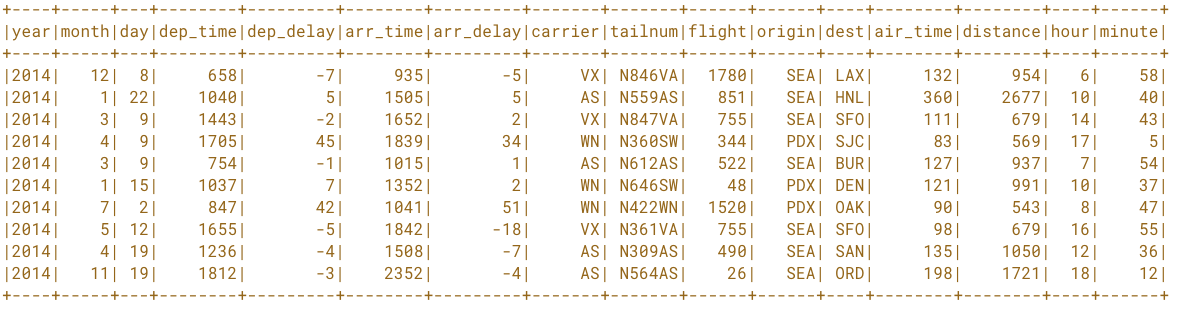


### Pandafy a Spark DataFrame
Suppose you've run a query on your huge dataset and aggregated it down to something a little more manageable.

Sometimes it makes sense to then take that table and work with it locally using a tool like pandas. Spark DataFrames make that easy with the .toPandas() method. Calling this method on a Spark DataFrame returns the corresponding pandas DataFrame. It's as simple as that!

This time the query counts the number of flights to each airport from SEA and PDX.

Remember, there's already a SparkSession called spark in your workspace!

```python
query = "SELECT origin, dest, COUNT(*) as N FROM flights GROUP BY origin, dest"

# Run the query
flight_counts = spark.sql(query)

# Convert the results to a pandas DataFrame
pd_counts = flight_counts.toPandas()

# Print the head of pd_counts
print(pd_counts.head())

```
### Put some Spark in your data
In the last exercise, you saw how to move data from Spark to pandas. However, maybe you want to go the other direction, and put a pandas DataFrame into a Spark cluster! The SparkSession class has a method for this as well.

The .createDataFrame() method takes a pandas DataFrame and returns a Spark DataFrame.

The output of this method is stored locally, not in the SparkSession catalog. This means that you can use all the Spark DataFrame methods on it, but you can't access the data in other contexts.

For example, a SQL query (using the .sql() method) that references your DataFrame will throw an error. To access the data in this way, you have to save it as a temporary table.

You can do this using the .createTempView() Spark DataFrame method, which takes as its only argument the name of the temporary table you'd like to register. This method registers the DataFrame as a table in the catalog, but as this table is temporary, it can only be accessed from the specific SparkSession used to create the Spark DataFrame.

There is also the method .createOrReplaceTempView(). This safely creates a new temporary table if nothing was there before, or updates an existing table if one was already defined. You'll use this method to avoid running into problems with duplicate tables.

Check out the diagram to see all the different ways your Spark data structures interact with each other.

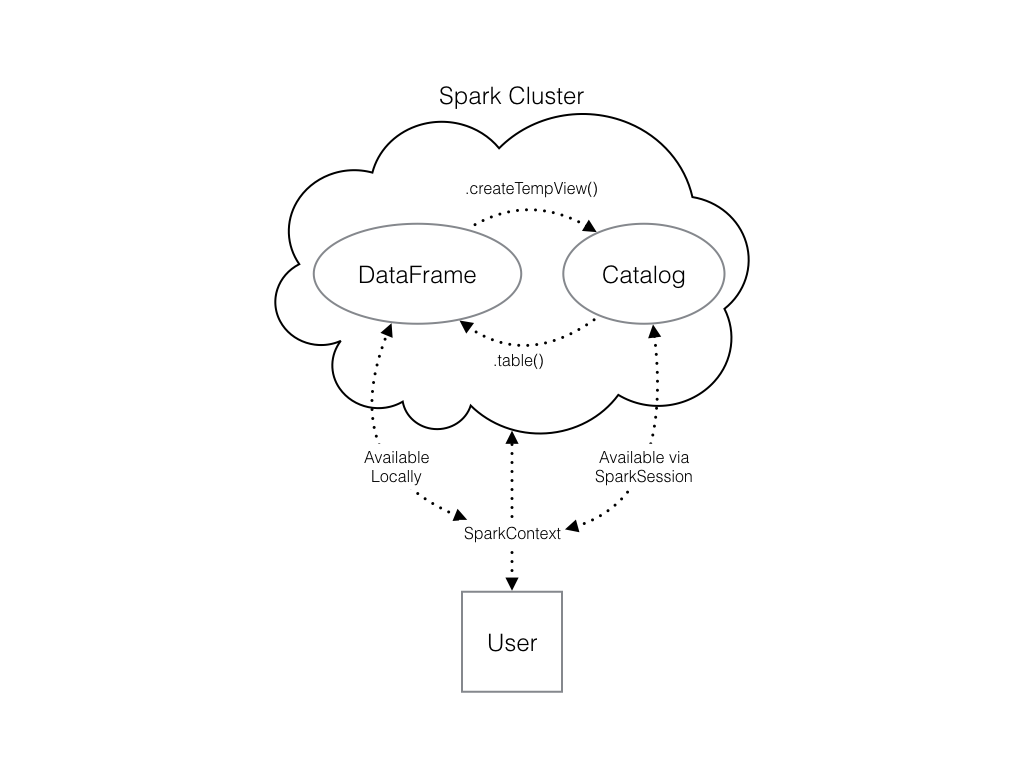


In [4]:
import pandas as pd
import numpy as np
# Create pd_temp
pd_temp = pd.DataFrame(np.random.random(10))

# Create spark_temp from pd_temp
spark_temp = spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(spark.catalog.listTables())

# Add spark_temp to the catalog
spark_temp.createOrReplaceTempView("temp")

# Examine the tables in the catalog again
print(spark.catalog.listTables())

[]
[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


### Dropping the middle man
Now you know how to put data into Spark via pandas, but you're probably wondering why deal with pandas at all? Wouldn't it be easier to just read a text file straight into Spark? Of course it would!

Luckily, your SparkSession has a .read attribute which has several methods for reading different data sources into Spark DataFrames. Using these you can create a DataFrame from a .csv file just like with regular pandas DataFrames!

The variable file_path is a string with the path to the file airports.csv. This file contains information about different airports all over the world.

A SparkSession named spark is available in your workspace.


In [5]:
file_path = 'data/airports.csv'

#Read in the airports path
airports = spark.read.csv(file_path, header=True)

airports.show()

+---+--------------------+----------------+-----------------+----+---+---+
|faa|                name|             lat|              lon| alt| tz|dst|
+---+--------------------+----------------+-----------------+----+---+---+
|04G|   Lansdowne Airport|      41.1304722|      -80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|      32.4605722|      -85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|      41.9893408|      -88.1012428| 801| -6|  A|
|06N|     Randall Airport|       41.431912|      -74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|      31.0744722|      -81.4277778|  11| -4|  A|
|0A9|Elizabethton Muni...|      36.3712222|      -82.1734167|1593| -4|  A|
|0G6|Williams County A...|      41.4673056|      -84.5067778| 730| -5|  A|
|0G7|Finger Lakes Regi...|      42.8835647|      -76.7812318| 492| -5|  A|
|0P2|Shoestring Aviati...|      39.7948244|      -76.6471914|1000| -5|  U|
|0S9|Jefferson County ...|      48.0538086|     -122.8106436| 108| -8|  A|
|0W3|Harford County Ai...

In [6]:
type(airports)

pyspark.sql.dataframe.DataFrame

In [7]:
my_spark.catalog.listDatabases()

[Database(name='default', description='Default Hive database', locationUri='file:/Users/aysbt/AnacondaProjects/DataCamp/spark-warehouse')]

In [8]:
my_spark.catalog.listTables()

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

## Manipulating data
### Creating columns
In this chapter, you'll learn how to use the methods defined by Spark's DataFrame class to perform common data operations.

Let's look at performing column-wise operations. In Spark you can do this using the .withColumn() method, which takes two arguments. First, a string with the name of your new column, and second the new column itself.

The new column must be an object of class Column. Creating one of these is as easy as extracting a column from your DataFrame using df.colName.

Updating a Spark DataFrame is somewhat different than working in pandas because the Spark DataFrame is immutable. This means that it can't be changed, and so columns can't be updated in place.

Thus, all these methods return a new DataFrame. To overwrite the original DataFrame you must reassign the returned DataFrame using the method like so:
```python
df = df.withColumn("newCol", df.oldCol + 1)
```
The above code creates a DataFrame with the same columns as df plus a new column, newCol, where every entry is equal to the corresponding entry from oldCol, plus one.

To overwrite an existing column, just pass the name of the column as the first argument!


In [9]:
flights = spark.read.csv('data/flights_small.csv', header=True)
flights.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

In [10]:
flights.name = flights.createOrReplaceTempView('flights')
my_spark.catalog.listTables()

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [11]:
# Create the DataFrame flights
flights_df = my_spark.table('flights')
print(flights_df.show())

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

In [12]:
#include a new column called duration_hrs
flights = flights.withColumn('duration_hrs', flights.air_time / 60)
flights.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|               2.2|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|               6.0|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|              1.85|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|1.3833333333333333|
|2014|    3|  9|     754|  

### Filtering Data
Let's take a look at the .filter() method. As you might suspect, this is the Spark counterpart of SQL's WHERE clause. The .filter() method takes either a Spark Column of boolean (True/False) values or the WHERE clause of a SQL expression as a string.

For example, the following two expressions will produce the same output:
```python
flights.filter(flights.air_time > 120).show()
flights.filter("air_time > 120").show()
```

In [13]:
# Filter flights with a SQL string
long_flights1 = flights.filter('distance > 1000')
# Filter flights with a boolean column
long_flights2 = flights.filter(flights.distance > 1000 )

long_flights1.show()
long_flights2.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|               6.0|
|2014|    4| 19|    1236|       -4|    1508|       -7|     AS| N309AS|   490|   SEA| SAN|     135|    1050|  12|    36|              2.25|
|2014|   11| 19|    1812|       -3|    2352|       -4|     AS| N564AS|    26|   SEA| ORD|     198|    1721|  18|    12|               3.3|
|2014|    8|  3|    1120|        0|    1415|        2|     AS| N305AS|   656|   SEA| PHX|     154|    1107|  11|    20| 2.566666666666667|
|2014|   11| 12|    2346|  

### Selecting
The Spark variant of SQL's SELECT is the .select() method. This method takes multiple arguments - one for each column you want to select. These arguments can either be the column name as a string (one for each column) or a column object (using the df.colName syntax). When you pass a column object, you can perform operations like addition or subtraction on the column to change the data contained in it, much like inside .withColumn().

The difference between .select() and .withColumn() methods is that .select() returns only the columns you specify, while .withColumn() returns all the columns of the DataFrame in addition to the one you defined. It's often a good idea to drop columns you don't need at the beginning of an operation so that you're not dragging around extra data as you're wrangling. In this case, you would use .select() and not .withColumn().

In [17]:
# Select the first set of columns as a string
selected_1 = flights.select('tailnum', 'origin', 'dest')

# Select the second set of columns usinf df.col_name
temp = flights.select(flights.origin, flights.dest, flights.carrier)

# Define first filter to only keep flights from SEA to PDX.
FilterA = flights.origin == 'SEA'
FilterB =flights.dest == 'PDX'

# Filter the data, first by filterA then by filterB
selected_2 = temp.filter(FilterA).filter(FilterB)

selected_2.show()

+------+----+-------+
|origin|dest|carrier|
+------+----+-------+
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     AS|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     AS|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
+------+----+-------+
only showing top 20 rows



Similar to SQL, you can also use the .select() method to perform column-wise operations. When you're selecting a column using the df.colName notation, you can perform any column operation and the .select() method will return the transformed column. For example,

```python
flights.select(flights.air_time/60)
```
returns a column of flight durations in hours instead of minutes. You can also use the .alias() method to rename a column you're selecting. So if you wanted to .select() the column duration_hrs (which isn't in your DataFrame) you could do

```python
flights.select((flights.air_time/60).alias("duration_hrs"))
```
The equivalent Spark DataFrame method .selectExpr() takes SQL expressions as a string:

flights.selectExpr("air_time/60 as duration_hrs")
with the SQL as keyword being equivalent to the .alias() method. To select multiple columns, you can pass multiple strings.

In [21]:
#Create a table of the average speed of each flight both ways.
#Calculate average speed by dividing the distance by the air_time (converted to hours).Use the .alias() method name
# Define avg_speed
avg_speed = (flights.distance/(flights.air_time/60)).alias("avg_speed")
speed_1 = flights.select('origin','dest','tailnum', avg_speed)

#Using the Spark DataFrame method .selectExpr() 
speed_2 =flights.selectExpr('origin','dest','tailnum','distance/(air_time/60) as avg_speed')
speed_2.show()


+------+----+-------+------------------+
|origin|dest|tailnum|         avg_speed|
+------+----+-------+------------------+
|   SEA| LAX| N846VA| 433.6363636363636|
|   SEA| HNL| N559AS| 446.1666666666667|
|   SEA| SFO| N847VA|367.02702702702703|
|   PDX| SJC| N360SW| 411.3253012048193|
|   SEA| BUR| N612AS| 442.6771653543307|
|   PDX| DEN| N646SW|491.40495867768595|
|   PDX| OAK| N422WN|             362.0|
|   SEA| SFO| N361VA| 415.7142857142857|
|   SEA| SAN| N309AS| 466.6666666666667|
|   SEA| ORD| N564AS| 521.5151515151515|
|   SEA| LAX| N323AS| 440.3076923076923|
|   SEA| PHX| N305AS|431.29870129870125|
|   SEA| LAS| N433AS| 409.6062992125984|
|   SEA| ANC| N765AS|474.75409836065575|
|   SEA| SFO| N713AS| 315.8139534883721|
|   PDX| SFO| N27205| 366.6666666666667|
|   SEA| SMF| N626AS|477.63157894736844|
|   SEA| MDW| N8634A|481.38888888888886|
|   SEA| BOS| N597AS| 516.4137931034483|
|   PDX| BUR| N215AG| 441.6216216216216|
+------+----+-------+------------------+
only showing top

### Aggregating
All of the common aggregation methods, like `.min()`, `.max()`, and `.count()` are GroupedData methods. These are created by calling the `.groupBy()` DataFrame method. For now, all you have to do to use these functions is call that method on your DataFrame. For example, to find the minimum value of a column, col, in a DataFrame, df, you could do
```python
df.groupBy().min("col").show()
```
This creates a GroupedData object (so you can use the .min() method), then finds the minimum value in col, and returns it as a DataFrame.

In [24]:
flights.describe()

DataFrame[summary: string, year: string, month: string, day: string, dep_time: string, dep_delay: string, arr_time: string, arr_delay: string, carrier: string, tailnum: string, flight: string, origin: string, dest: string, air_time: string, distance: string, hour: string, minute: string, duration_hrs: string]

In [29]:
#arr_time: string and distance: string, so to find min() and max() we need to convert this float 
flights = flights.withColumn('distance', flights.distance.cast('float'))
flights = flights.withColumn('air_time', flights.air_time.cast('float'))

flights.describe('air_time', 'distance').show()

+-------+------------------+-----------------+
|summary|          air_time|         distance|
+-------+------------------+-----------------+
|  count|              9925|            10000|
|   mean|152.88423173803525|        1208.1516|
| stddev|  72.8656286392139|656.8599023464376|
|    min|              20.0|             93.0|
|    max|             409.0|           2724.0|
+-------+------------------+-----------------+



In [31]:
#Find the length of the shortest (in terms of distance) flight that left PDX 
flights.filter(flights.origin =='PDX').groupBy().min('distance').show()

#Find the length of the longest (in terms of time) flight that left SEA
flights.filter(flights.origin == 'SEA').groupBy().max('air_time').show()

+-------------+
|min(distance)|
+-------------+
|        106.0|
+-------------+

+-------------+
|max(air_time)|
+-------------+
|        409.0|
+-------------+



In [32]:
#get the average air time of Delta Airlines flights  that left SEA. 
flights.filter(flights.carrier == 'DL').filter(flights.origin == 'SEA').groupBy().avg('air_time').show()


+------------------+
|     avg(air_time)|
+------------------+
|188.20689655172413|
+------------------+



In [33]:
#get the total number of hours all planes in this dataset spent in the air by creating a column called duration_hrs
flights.withColumn('duration_hrs', flights.air_time/60).groupBy().sum('duration_hrs').show()

+------------------+
| sum(duration_hrs)|
+------------------+
|25289.600000000126|
+------------------+

